In [1]:
# files and system
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

In [4]:
import torch
import torchvision

import torchsummary

In [5]:
torch.cuda.is_available()

True

# EDA

## Pre-defined split

In [6]:
os.listdir('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val')

['val.txt', 'train.txt', 'README.md']

In [7]:
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/train.txt', 'r') as f:
    print(len([l.strip()+'.jpg' for l in f]))
    
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/val.txt', 'r') as f:
    print(len([l.strip()+'.jpg' for l in f]))

880
120


## Random Image/Mask pair

In [8]:
img = imageio.imread('../datasets/train-val/images/cju5buy2bal250818ipl6fqwv.jpg')
img.shape

(430, 569, 3)

In [9]:
mask = imageio.imread('../datasets/train-val/masks/cju5buy2bal250818ipl6fqwv.jpg')
# np.all(mask[:, :, 1] == mask[:, :, 2])
mask[:, :, 0].shape


(430, 569)

In [25]:
def iou_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean()

# Dataloader

In [10]:
# Method 2: Save images to folder and create a custom dataloader that loads them from their path. More involved than method 1 but allows for greater flexibility
# Requires 3 functions: __init__ to initialize the object, and __len__ and __get__item for pytorch purposes. More functions can be added as needed, but those 3 are necessary for it to function with pytorch
class myDataSet(object):

    def __init__(self, ids, path_images, path_masks):
        "Initialization"
        self.ids = ids
        self.path_images = path_images
        self.path_masks = path_masks

    def __len__(self):
        "Returns length of dataset"
        return len(self.ids)  

    def __getitem__(self, index):
        "Return next item of dataset"
        # Define path to current image and corresponding mask
        path_img = os.path.join(self.path_images, self.ids[index])
        path_mask = os.path.join(self.path_masks, self.ids[index])

        # Load image and mask
        #img = cv2.imread(path_img)
        img = imageio.imread(path_img)
        mask = imageio.imread(path_mask)[:,:,0] # mask from .jpeg has 3 channels ()
        
        #print(path_img, img.shape, mask.shape, np.unique(mask))
        #assert img.shape == mask.shape

        # Here you can implement any transformations you would like to apply to the image/mask
        #
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))
        mask = mask > 100 # binarize so there are no intencities like 1, 2, 3, 251, 253, 255

        # Convert to tensor and return
        img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])) # Pytorch uses the channels in the first dimension
        mask = torch.FloatTensor(mask).unsqueeze(0) # Adding channel dimension to label

        return img, mask

path_images = "../datasets/train-val/images"
path_masks = "../datasets/train-val/masks"


# pre-defined split
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]
# ids = np.array(os.listdir("../datasets/train-val/images")) # list of filenames to be used
# indices = torch.randperm(len(os.listdir(path_images))).tolist()
# ids_train = ids[indices[:int(len(indices)*0.8)]]
# ids_val = ids[indices[-int(len(indices)*0.2):]]


custom_dataset_train = myDataSet(ids_train, path_images, path_masks)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [17]:
batch_size = 5

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=True, num_workers=2)

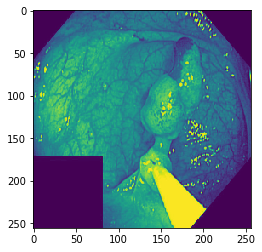

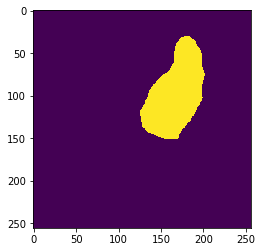

In [18]:
# Show example images.
image_number = 23

# image
plt.figure()
plt.imshow(custom_dataset_train.__getitem__(image_number)[0].mean(0))

# mask
plt.figure()
plt.imshow(custom_dataset_train.__getitem__(image_number)[1][0, :, :])

plt.show()

In [19]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [20]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

# Model Architecture

In [26]:
# Define your model. In this case we're using a basic UNet architecture. The output channel for segmentation should be equal to number of classes we want to segment the image into. For a binary segmentation, this is a value of 1.
class UNet(torch.nn.Module):

    def conv_block(self, channel_in, channel_out):
        return torch.nn.Sequential(
            torch.nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True)
        )


    def __init__(self, channel_in, channel_out, bilinear=None):
        super(UNet, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        # initial convolutional block
        self.initial = self.conv_block(channel_in, 64)
        
        # encoder layers
        self.down0 = self.conv_block(64, 128)
        self.down1 = self.conv_block(128, 256)
        self.down2 = self.conv_block(256, 512)
        self.down3 = self.conv_block(512, 1024)
        
        # decoder layers
        self.up0_0 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up0_1 = self.conv_block(1024, 512)
        self.up1_0 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up1_1 = self.conv_block(512, 256)
        self.up2_0 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2_1 = self.conv_block(256, 128)
        self.up3_0 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3_1 = self.conv_block(128, 64)
        
        # final layer before output
        self.final = torch.nn.Conv2d(64, channel_out, kernel_size=1)

    def forward(self,x):
        "Forward pass"
        x_in= self.initial(x)
        enc0 = self.down0(torch.nn.MaxPool2d(2)(x_in))
        enc1 = self.down1(torch.nn.MaxPool2d(2)(enc0))
        enc2 = self.down2(torch.nn.MaxPool2d(2)(enc1))
        enc3 = self.down3(torch.nn.MaxPool2d(2)(enc2))
        
        dec0 = self.up0_0(enc3)
        diff0 = torch.FloatTensor(list(enc2.size())[2:]) - torch.FloatTensor(list(dec0.shape))[2:]
        dec0 = torch.nn.functional.pad(dec0, (int((diff0/2).floor()[0]), int((diff0/2).ceil()[0]), int((diff0/2).floor()[1]), int((diff0/2).ceil()[1])))
        dec0 = self.up0_1(torch.cat((enc2, dec0), dim=1))

        dec1 = self.up1_0(dec0)
        diff1 = torch.FloatTensor(list(enc1.size())[2:]) - torch.FloatTensor(list(dec1.shape))[2:]
        dec1 = torch.nn.functional.pad(dec1, (int((diff1/2).floor()[0]), int((diff1/2).ceil()[0]), int((diff1/2).floor()[1]), int((diff1/2).ceil()[1])))
        dec1 = self.up1_1(torch.cat((enc1, dec1), dim=1))

        dec2 = self.up2_0(dec1)
        diff2 = torch.FloatTensor(list(enc0.size())[2:]) - torch.FloatTensor(list(dec2.shape))[2:]
        dec2 = torch.nn.functional.pad(dec2, (int((diff2/2).floor()[0]), int((diff2/2).ceil()[0]), int((diff2/2).floor()[1]), int((diff2/2).ceil()[1])))
        dec2 = self.up2_1(torch.cat((enc0, dec2), dim=1))

        dec3 = self.up3_0(dec2)
        diff3 = torch.FloatTensor(list(x.size())[2:]) - torch.FloatTensor(list(dec3.shape))[2:]
        dec3 = torch.nn.functional.pad(dec3, (int((diff3/2).floor()[0]), int((diff3/2).ceil()[0]), int((diff3/2).floor()[1]), int((diff3/2).ceil()[1])))
        dec3 = self.up3_1(torch.cat((x_in, dec3), dim=1))

        x_out = self.final(dec3)
        return x_out

model = UNet(channel_in=3, channel_out= 1)
torchsummary.summary(model, (3, 256, 256), device="cpu") # Runs a basic test of the network. Very useful and clear!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
      BatchNorm2d-14          [-1, 256,

# Training hyperparameters

In [27]:
# Define variables for the training
epochs = 10
lr = 0.001 # learning rate

In [28]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# Training

In [29]:
# Begin training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
model = model.to(device) # load model to device
for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(device), masks.to(device)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs = imgs.to(device)
        masks = masks.to(device)
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
    print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/len(dataloader_val)))

 Epoch: 0 of 10, Iter.: 176 of 176, Loss: 0.392530, Val. Loss: 0.390310
 Epoch: 1 of 10, Iter.: 176 of 176, Loss: 0.352054, Val. Loss: 0.373968
 Epoch: 2 of 10, Iter.: 176 of 176, Loss: 0.349470, Val. Loss: 0.368950
 Epoch: 3 of 10, Iter.: 176 of 176, Loss: 0.348349, Val. Loss: 0.368568
 Epoch: 4 of 10, Iter.: 176 of 176, Loss: 0.347300, Val. Loss: 0.374907
 Epoch: 5 of 10, Iter.: 176 of 176, Loss: 0.345234, Val. Loss: 0.374597
 Epoch: 6 of 10, Iter.: 176 of 176, Loss: 0.343051, Val. Loss: 0.380497
 Epoch: 7 of 10, Iter.: 176 of 176, Loss: 0.341062, Val. Loss: 0.369913
 Epoch: 8 of 10, Iter.: 128 of 176, IoU:  0.025189

KeyboardInterrupt: 